<a href="https://colab.research.google.com/github/rboghe/cened/blob/master/cened_1_2_ml.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [1]:
import os
import urllib.request
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, make_scorer
from sklearn.model_selection import RandomizedSearchCV
import scipy.stats as stats
from lightgbm import LGBMRegressor, plot_importance
import seaborn as sns

# Silence panda's setting with copy warning
pd.options.mode.chained_assignment = None

# Set Seaborn style
sns.set_theme(style="white")

# Load data

In [3]:
# Cened 1.2
url = 'https://www.dati.lombardia.it/api/views/rsg3-xhvk/rows.csv?accessType=DOWNLOAD'


if os.path.isfile('/tmp/cened12.csv'):
  pass
else:
  urllib.request.urlretrieve(url, '/tmp/cened12.csv')

In [23]:
# DDH
url = 'https://raw.githubusercontent.com/rboghe/cened/master/degreedays.txt'

urllib.request.urlretrieve(url, '/tmp/ddh.csv')

ddh = pd.read_csv('/tmp/ddh.csv', usecols = ['comune','dd'])

In [24]:
cols = ['COMUNE','FOGLIO', 'PARTICELLA','SUPERFICIE_DISPERDENTE',
          'TRASMITTANZA_MEDIA_COPERTURA','TRASMITTANZA_MEDIA_INVOLUCRO',
          'TRASMITTANZA_MEDIA_BASAMENTO','TRASMITTANZA_MEDIA_SERRAMENTO',
          'SUPERFICIE_LORDA', 'VOLUME_LORDO', 'DESTINAZIONE_DI_USO',
          'ANNO_COSTRUZIONE','SUPERFICIE_VETRATA_OPACA', 'VOLUME_NETTO',
          'SUPERFICIE_NETTA', 'NUMERO_RICAMBI_ORARI', 'EPH']
  
cened_old = pd.read_csv('/tmp/cened12.csv', usecols = cols)

In [25]:
# Full DB of residential buildings without missing data
print(len(cened_old))

1206361


# Preprocessing

In [26]:
# Drop buildings with NaN values
cened_old.dropna(inplace = True)

# We'll use residential buildings only
cened_old = cened_old[cened_old['DESTINAZIONE_DI_USO'] == 'E.1(1)']

# Add ddh
cened_old['COMUNE'] = cened_old['COMUNE'].str.lower()
ddh['comune'] = ddh['comune'].str.lower()
cened_old['COMUNE'] = cened_old['COMUNE'].str.replace(r"o`",  "o'")
cened_old['COMUNE'] = cened_old['COMUNE'].str.replace(r"baranzate",  "bollate")
cened_old['COMUNE'] = cened_old['COMUNE'].str.replace(r"bovisio masciago",  "bovisio-masciago")
cened_old['COMUNE'] = cened_old['COMUNE'].str.replace(r"cornate d`adda",  "cornate d'adda")
cened_old['COMUNE'] = cened_old['COMUNE'].str.replace(r"cortenuova",  "cortenova")
cened_old['COMUNE'] = cened_old['COMUNE'].str.replace(r"sant'omobono terme",  "sant'omobono imagna")
ddh['comune'] = ddh['comune'].str.replace(r"è",  "e'")
ddh['comune'] = ddh['comune'].str.replace(r"è",  "e'")
ddh['comune'] = ddh['comune'].str.replace(r"é",  "e'")
ddh['comune'] = ddh['comune'].str.replace(r"ò",  "o'")
ddh['comune'] = ddh['comune'].str.replace(r"ù",  "u'")

cened_old = cened_old.merge(ddh, left_on='COMUNE', right_on='comune', how='left')



# Correct floats
for col in ['SUPERFICIE_LORDA', 'SUPERFICIE_NETTA', 'VOLUME_LORDO', 'VOLUME_NETTO',
       'SUPERFICIE_DISPERDENTE', 'SUPERFICIE_VETRATA_OPACA',
       'TRASMITTANZA_MEDIA_INVOLUCRO', 'TRASMITTANZA_MEDIA_COPERTURA',
       'TRASMITTANZA_MEDIA_BASAMENTO', 'TRASMITTANZA_MEDIA_SERRAMENTO', 'EPH', 'dd']:
    cened_old[col] = cened_old[col].astype(str)
    cened_old[col] = cened_old[col].str.replace(r',', '')
    cened_old[col] = cened_old[col].astype("float")

In [27]:
# Full DB of residential buildings without missing data
print(len(cened_old))

243140


# Feature engineering

In [28]:
# Opaque surface
cened_old['SUP_OPACA'] = cened_old['SUPERFICIE_DISPERDENTE']/(1+cened_old['SUPERFICIE_VETRATA_OPACA'])

# Opaque surface
cened_old['SUP_FINESTRATA'] = cened_old['SUPERFICIE_DISPERDENTE'] - cened_old['SUP_OPACA']

# Take care of construction year
cened_old.ANNO_COSTRUZIONE = cened_old.ANNO_COSTRUZIONE.astype(str)
cened_old.ANNO_COSTRUZIONE = cened_old.ANNO_COSTRUZIONE.map(lambda x:x[-4:])
cened_old.ANNO_COSTRUZIONE = cened_old.ANNO_COSTRUZIONE.astype(int)

cened_old['PERIODO'] = pd.cut(cened_old.ANNO_COSTRUZIONE, bins=[0,1930,1945,1960,1976,1992,2006,3000],
     labels=['Before 1930','1930-1945','1946-1960','1961-1976', '1977-1992', '1993-2006','After 2006']).cat.codes

# Take care of ach
cened_old.NUMERO_RICAMBI_ORARI = cened_old.NUMERO_RICAMBI_ORARI.astype(str)
cened_old.NUMERO_RICAMBI_ORARI = cened_old.NUMERO_RICAMBI_ORARI.map(lambda x:x[:6])
cened_old.NUMERO_RICAMBI_ORARI = cened_old.NUMERO_RICAMBI_ORARI.astype(float)

# Filtering

Taken from previous studies!

In [29]:
# Drop buildings with wrong thermal conductivity
for col in ['TRASMITTANZA_MEDIA_INVOLUCRO', 'TRASMITTANZA_MEDIA_COPERTURA',
       'TRASMITTANZA_MEDIA_BASAMENTO']:
    cened_old = cened_old[cened_old[col] > 0]
    cened_old = cened_old[cened_old[col] < 4]

cened_old = cened_old[cened_old['TRASMITTANZA_MEDIA_SERRAMENTO'] > 0]
cened_old = cened_old[cened_old['TRASMITTANZA_MEDIA_SERRAMENTO'] < 6]

# Drop buildings with wrong EPH
cened_old = cened_old[cened_old['EPH'] > 5]
cened_old = cened_old[cened_old['EPH'] < 1000]

# Drop buildings with wrong An
cened_old = cened_old[cened_old['SUPERFICIE_NETTA'] > 50]

# Drop buildings with wrong Vn
cened_old = cened_old[cened_old['VOLUME_NETTO'] > 150]

# Drop buildings with wrong average height
cened_old['ALTEZZA_MEDIA'] = cened_old['VOLUME_NETTO']/cened_old['SUPERFICIE_NETTA']
cened_old = cened_old[cened_old['ALTEZZA_MEDIA'] > 2.4]


# Drop buildings with wrong mean thermal conductivity
cened_old['TRASMITTANZA_MEDIA'] = (cened_old['TRASMITTANZA_MEDIA_SERRAMENTO'] + cened_old['TRASMITTANZA_MEDIA_COPERTURA'] +
         cened_old['TRASMITTANZA_MEDIA_BASAMENTO'] + cened_old['TRASMITTANZA_MEDIA_INVOLUCRO'])/4

cened_old = cened_old[cened_old['TRASMITTANZA_MEDIA'] > 0.15]
cened_old = cened_old[cened_old['TRASMITTANZA_MEDIA'] < 4]

# Glazed surface
cened_old = cened_old[cened_old['SUP_FINESTRATA'] > 1]

# Glazing ratio
cened_old = cened_old[cened_old['SUPERFICIE_VETRATA_OPACA'] > 0]
cened_old = cened_old[cened_old['SUPERFICIE_VETRATA_OPACA'] < 0.9]

In [30]:
print(len(cened_old))

209285


# Data analysis

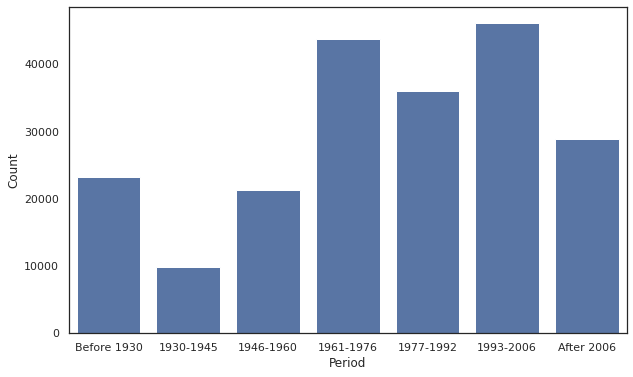

In [31]:
# Period
fig = plt.figure(figsize = (10,6))
cplot = sns.countplot(x = pd.cut(cened_old.ANNO_COSTRUZIONE, bins=[0,1930,1945,1960,1976,1992,2006,3000], 
       labels=['Before 1930','1930-1945','1946-1960','1961-1976', '1977-1992', 
               '1993-2006','After 2006']), color = 'b')
cplot.set(ylabel = 'Count', xlabel = 'Period')
plt.show()

# Shuffle

In [32]:
cened = cened_old.sample(frac=1).reset_index(drop=True)

# Reserve a test set

In [33]:
msk = np.random.rand(len(cened)) < 0.8
train = cened[msk]
test = cened[~msk]

In [34]:
print(len(train))

167364


In [35]:
print(len(test))

41921


# Define MAPE

In [36]:
def neg_mape(y_true, y_pred):
  y_true = np.array(y_true)
  y_pred = np.array(y_pred)
  return -np.abs((y_true - y_pred)/y_true).mean()

In [37]:
def modified_neg_mape(y_true, y_pred):
  y_true = np.array(y_true)
  y_pred = np.array(y_pred)
  errors = np.abs((y_true - y_pred)/y_true)
  index = np.argwhere(errors > 1)
  mod_errors = np.delete(errors, index)
  return -mod_errors.mean()

In [38]:
neg_mape_scorer = make_scorer(neg_mape, greater_is_better=True)

In [39]:
modified_neg_mape_scorer = make_scorer(modified_neg_mape, greater_is_better=True)

# Random search

In [40]:
mlcol = ['PERIODO','SUPERFICIE_LORDA', 'SUPERFICIE_NETTA', 'VOLUME_LORDO', 
         'VOLUME_NETTO', 'SUPERFICIE_DISPERDENTE',
         'TRASMITTANZA_MEDIA_INVOLUCRO', 'TRASMITTANZA_MEDIA_COPERTURA',
         'TRASMITTANZA_MEDIA_BASAMENTO', 'TRASMITTANZA_MEDIA_SERRAMENTO',
         'dd','SUP_FINESTRATA','SUP_OPACA', 'SUPERFICIE_VETRATA_OPACA',
         'NUMERO_RICAMBI_ORARI', 'ALTEZZA_MEDIA']

In [41]:
cat_feats = ['PERIODO']

In [51]:
param_dist = {'feature_fraction': np.linspace(0.4, 1, num=7),
              'num_leaf' : list(range(20,40)),
             'max_depth' : [-1],
             'max_bin' : [100, 200, 300, 500, 750, 1000, 2000],
             'bagging_fraction' : np.linspace(0.4, 1, num=14),
             'bagging_freq' : list(range(1,10)),
             'lambda_l1' : stats.uniform(0, 0.6),
             'lambda_l2' : stats.uniform(0, 0.6)}

lgbm = LGBMRegressor(n_estimators = 200, silent = True, verbose = 0, is_training_metric = True, n_jobs = 1, 
                     eval_metric  = 'mape')

n_iter_search = 100

random_search = RandomizedSearchCV(lgbm, param_distributions=param_dist, n_iter=n_iter_search, 
                                   scoring={'MAPE' : neg_mape_scorer, 'MAPE <100%' : modified_neg_mape_scorer, 'R2' : 'r2'} , cv = 5, n_jobs = 6, verbose = 2, refit = 'MAPE <100%')

random_search.fit(cened[mlcol], cened['EPH'], categorical_feature = cat_feats)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   3 out of   5 | elapsed:   24.1s remaining:   16.1s
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:   24.2s finished
/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['PERIODO']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=LGBMRegressor(boosting_type='gbdt',
                                           class_weight=None,
                                           colsample_bytree=1.0,
                                           eval_metric='mape',
                                           importance_type='split',
                                           is_training_metric=True,
                                           learning_rate=0.1, max_depth=-1,
                                           min_child_samples=20,
                                           min_child_weight=0.001,
                                           min_split_gain=0.0, n_estimators=200,
                                           n_jobs=1, num_leaves=31,
                                           objective=None, random_sta...
                                        'lambda_l2': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f697ad2c710>,
            

# Print results

In [52]:
print(random_search.best_params_)

{'bagging_fraction': 0.6307692307692307, 'bagging_freq': 8, 'feature_fraction': 0.8, 'lambda_l1': 0.19034193349753936, 'lambda_l2': 0.5918067691279277, 'max_bin': 200, 'max_depth': -1, 'num_leaf': 21}


In [53]:
print(random_search.best_score_)

-0.16811002300015965


In [54]:
# Create a results df
cv_df = pd.DataFrame(random_search.cv_results_)
cv_df = cv_df.sort_values(by = ['rank_test_MAPE']).reset_index()

# Filter columns
res_cols = [col for col in cv_df if col.startswith('split')]

# Select best iter
best_res = cv_df.loc[0]

# Print results for each fold
print(best_res[res_cols])

split0_test_Full MAPE   -0.203469
split1_test_Full MAPE   -0.205252
split2_test_Full MAPE   -0.204338
split3_test_Full MAPE   -0.199418
split4_test_Full MAPE   -0.202697
split0_test_MAPE        -0.167375
split1_test_MAPE        -0.168379
split2_test_MAPE        -0.168932
split3_test_MAPE        -0.167174
split4_test_MAPE         -0.16869
split0_test_R2           0.873016
split1_test_R2           0.875417
split2_test_R2           0.874762
split3_test_R2           0.871132
split4_test_R2            0.87291
Name: 0, dtype: object


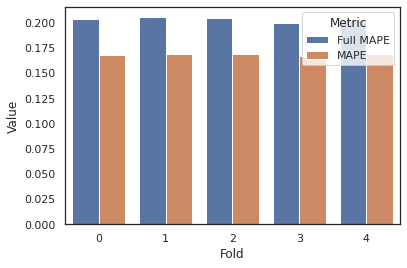

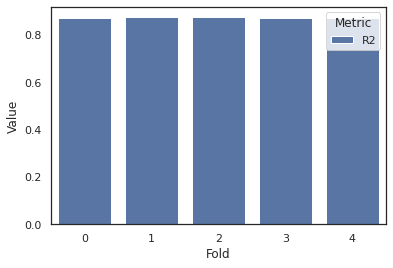

In [58]:
df = pd.DataFrame(best_res[res_cols])
df = df.rename(columns = {0:'Value'})
df['Fold'] = df.index.str[5:6]
df['Metric'] = df.index.str[12:]
df['Value'] = np.where(df['Metric'] == 'R2', df['Value'], df['Value'] * -1)
ax = sns.barplot(x='Fold', y="Value", hue="Metric", data = df[df['Metric'] != 'R2'])
plt.show()
ax = sns.barplot(x='Fold', y="Value", hue="Metric", data = df[df['Metric'] == 'R2'])
plt.show()

# Train the final model

In [ ]:
light = LGBMRegressor(n_estimators = 10000, silent = False, verbose = 2, is_training_metric = True, n_jobs = 6)
light.set_params(**random_search.best_params_)

In [ ]:
light.fit(train[mlcol], train['EPH'], categorical_feature = cat_feats)

# Test the model

In [ ]:
y_pred = light.predict(test[mlcol]).clip(0)

In [ ]:
results_df = pd.DataFrame({'predicted' : y_pred, 'true' : test['EPH']})
results_df['error'] = np.abs((results_df['true'] - results_df['predicted'])/results_df['true'])*100

In [ ]:
# MAPE
results_df['error'].mean()

In [ ]:
# Max % error
results_df['error'].max()

In [ ]:
# Row with the highest % error
results_df.iloc[results_df['error'].argmax()]

In [ ]:
# MAPE without >100%
results_df[results_df.error <= 100].error.mean()

In [ ]:
# R2 
print(r2_score(test['EPH'], y_pred))

In [ ]:
# R2 without >100%
print(r2_score(results_df[results_df.error <= 100].true, results_df[results_df.error <= 100].predicted))

In [ ]:
results_df

In [ ]:
plot_importance(light)

# Error analysis

In [ ]:
# Period
bins = pd.cut(test.ANNO_COSTRUZIONE, bins=[0,1930,1945,1960,1976,1992,2006,3000], 
       labels=['Before 1930','1930-1945','1946-1960','1961-1976', '1977-1992', 
               '1993-2006','After 2006'])

fig = plt.figure(figsize = (12, 4.5))
box = sns.boxplot(y = results_df.error, x = bins, 
                  color='lightsteelblue', orient = 'v', 
                  showfliers = False)

box.set(ylabel = 'MAPE [%]', xlabel = 'Period')
plt.show()

In [ ]:
# Error
fig = plt.figure(figsize = (10,6))
cplot = sns.countplot(x = pd.cut(results_df.error, bins=[0,10,20,30,40,50,60,70,80,90,100,10000],
                                 labels = ['<10', '10-20', '20-30', '30-40', '40-50', '50-60', '60-70', '70-80', '80-90', '90-100', '>100']), color = 'b')
cplot.set(ylabel = 'Count', xlabel = 'MAPE [%]')
plt.show()

In [ ]:
# Scatterplot
fig = plt.figure(figsize = (7,6))
scatter = sns.scatterplot(data=results_df, x="predicted", y="true")
scatter.set(ylabel = 'True', xlabel = 'Predicted',
            xlim=(-30, 1030), ylim=(-30, 1030))
m, b = np.polyfit(results_df['predicted'], results_df['true'], 1)
plt.plot(results_df['predicted'].values, m*results_df['predicted'] + b)
plt.plot([0, 1000], [0,1000], c = 'r', linestyle='--')
plt.show()